In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

## Connect to the database and create dataframes for each table

In [4]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordat

## Merge and clean the cities, states and countries tables

In [5]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [6]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [7]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,432,Kit,Lambert,45,homicide,rock,50388
2,459,Rusty,Day,36,homicide,rock,117057
3,481,Felix,Pappalardi,43,homicide,rock,122795
4,2,Kurt,Cobain,27,suicide,rock,110979
...,...,...,...,...,...,...,...
496,37,Johnny,Cash,71,diabetes,country,114248
497,148,A.,Carter,68,unknown,country,126050
498,380,Sara,Carter,80,unknown,country,125539
499,478,William,Walton,80,natural,classical,50807


In [8]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [9]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [10]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,473,Billy,Fury,42,heart disease,rock,Liverpool,England,United Kingdom
3,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
4,432,Kit,Lambert,45,homicide,rock,London,England,United Kingdom
...,...,...,...,...,...,...,...,...,...
495,301,Don,Rich,32,car/motorcycle accident,country,Olympia,Washington,United States
496,37,Johnny,Cash,71,diabetes,country,Cleveland County,Arkansas,United States
497,380,Sara,Carter,80,unknown,country,Russell County,Virginia,United States
498,478,William,Walton,80,natural,classical,Oldham,England,United Kingdom


## Create plots to observe the data

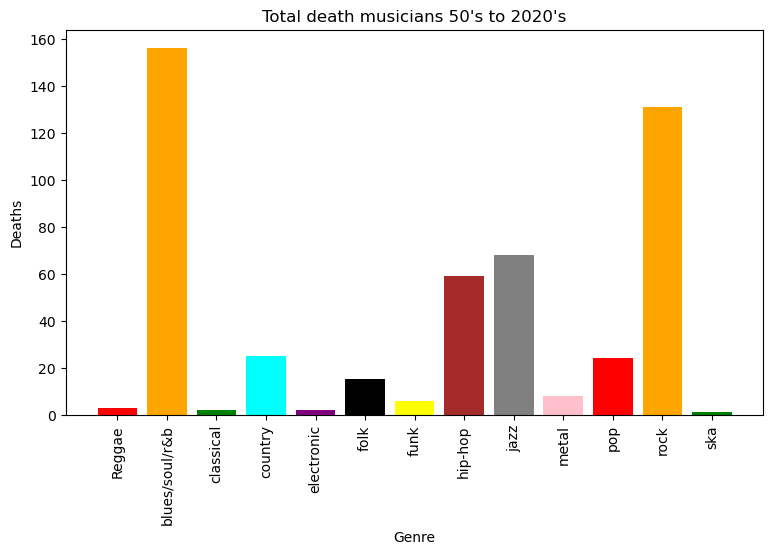

In [11]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5))
plt.bar(df_n.index, df_n, color=
        ['red', 'orange', 'green',
         'cyan', 'purple', 'black',
         'yellow', 'brown', 'grey', 'pink'])
plt.title("Total death musicians 50's to 2020's")
plt.ylabel("Deaths")
plt.xlabel("Genre")
plt.xticks(rotation='vertical')
plt.show()

## Cause of death per music genre

In [12]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause    genre         
AIDS     electronic         1
         pop                1
         rock               2
Burned   blues/soul/r&b     1
Falling  rock               1
                           ..
unknown  electronic         1
         folk               2
         jazz              10
         pop                3
         rock               3
Length: 94, dtype: int64

# Questions

## Most common Death Ages


In [13]:
n_da = musician['death_age'].value_counts().nlargest(10)

In [14]:
n_da

27    26
32    24
28    16
37    16
34    14
33    14
47    13
24    13
25    13
39    13
Name: death_age, dtype: int64

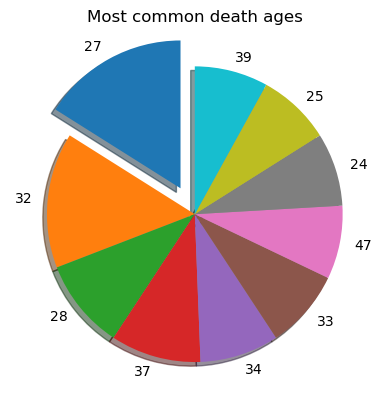

In [15]:

plt.pie(n_da.values, labels=n_da.index, 
        startangle=90,
        shadow=True,
        explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.title("Most common death ages")
plt.show()

## Most common Music Genre

In [16]:
n_mg = musician['genre'].value_counts()

In [17]:
n_mg

blues/soul/r&b    156
rock              131
jazz               68
hip-hop            59
country            25
pop                24
folk               15
metal               8
funk                6
Reggae              3
electronic          2
classical           2
ska                 1
Name: genre, dtype: int64

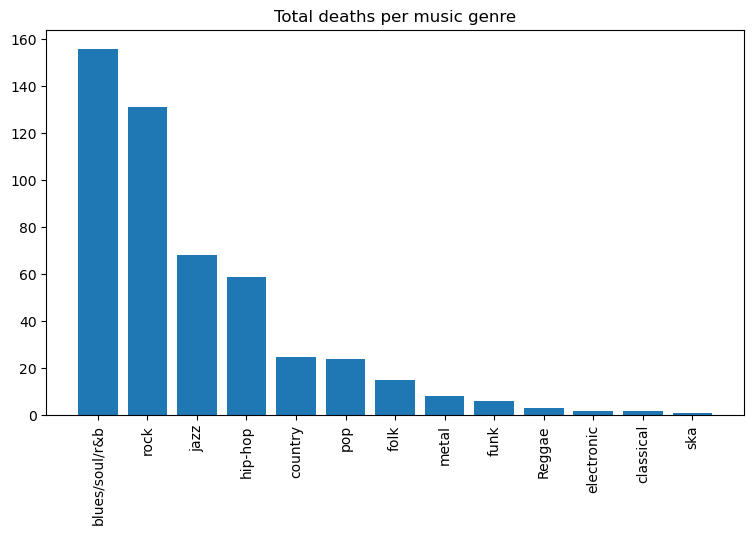

In [39]:
plt.figure(figsize=(9,5))
plt.bar(n_mg.index, n_mg.values)
plt.xticks(rotation='vertical')
plt.title("Total deaths per music genre")
plt.show()

# Places

### Most common Countries

In [19]:
n_places = musician['Country'].value_counts().nlargest(10)

In [20]:
n_places

United States     403
United Kingdom     52
Canada              6
Jamaica             5
Germany             4
Australia           4
South Africa        2
New Zealand         2
Spain               2
Lithuania           2
Name: Country, dtype: int64

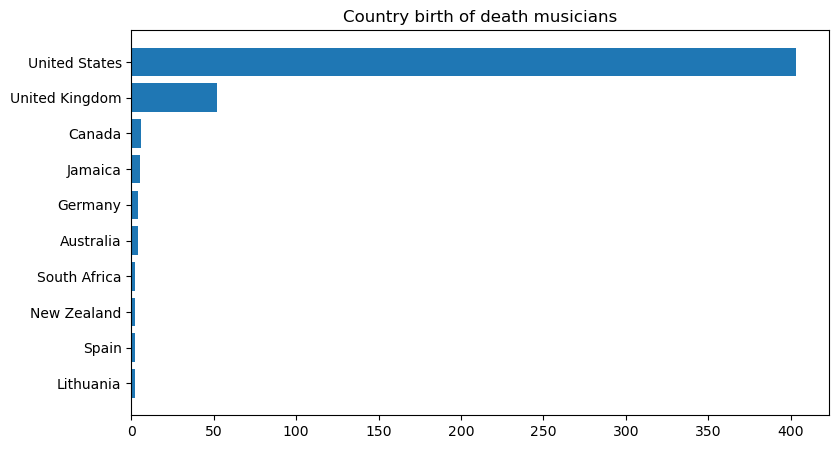

In [40]:
plt.figure(figsize=(9,5))
plt.barh(n_places.iloc[::-1].index, n_places.iloc[::-1].values)
plt.title("Country birth of death musicians")
plt.show()

### Most common States

In [22]:
n_states = musician['State'].value_counts().nlargest(10)

In [23]:
n_states

Mississippi     45
England         42
New York        42
Texas           32
California      30
Louisiana       26
Tennessee       25
Pennsylvania    18
Georgia         16
Illinois        16
Name: State, dtype: int64

### Most common Cities

In [24]:
n_cities = musician['City'].value_counts().nlargest(10)

In [25]:
n_cities

New York City    24
London           16
Chicago          14
Philadelphia     14
Los Angeles      12
New Orleans      12
Memphis          11
Birmingham       10
Detroit           6
Queens            5
Name: City, dtype: int64

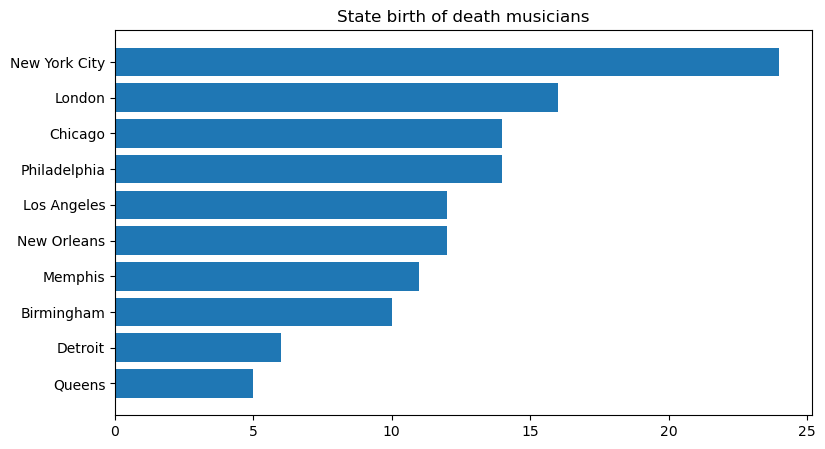

In [41]:
plt.figure(figsize=(9, 5))
plt.barh(n_cities.iloc[::-1].index, n_cities.iloc[::-1].values)
plt.title("State birth of death musicians")
plt.show()

## Death genre - cause

In [27]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [28]:
n_cd_gr

genre           cause            
hip-hop         homicide             58
blues/soul/r&b  heart disease        44
rock            drug overdose        23
blues/soul/r&b  cancer               22
rock            heart disease        22
                                     ..
jazz            suicide               1
                surgery               1
                tuberculosis          1
metal           aircraft accident     1
ska             suicide               1
Length: 94, dtype: int64

In [29]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [30]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues/soul/r&b,heart disease,44
2,rock,drug overdose,23
3,blues/soul/r&b,cancer,22
4,rock,heart disease,22
...,...,...,...
89,jazz,suicide,1
90,jazz,surgery,1
91,jazz,tuberculosis,1
92,metal,aircraft accident,1


### Blues 

In [31]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [42]:
n_blues

,genre,cause,deaths


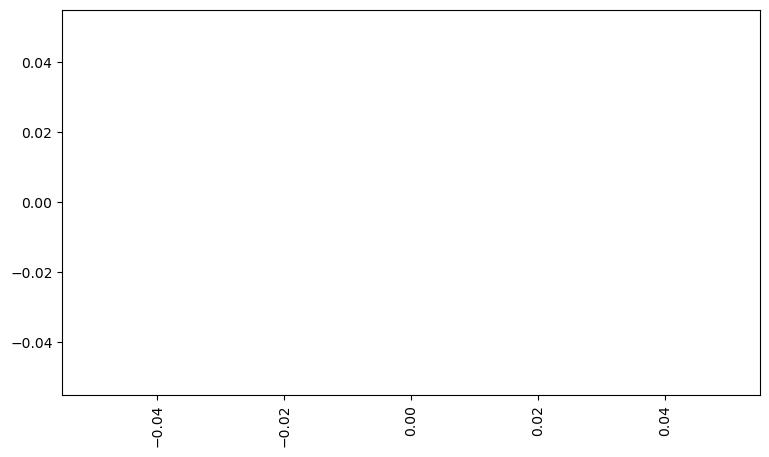

In [33]:
plt.figure(figsize=(9,5))
plt.bar(n_blues['cause'], n_blues['deaths'])
plt.xticks(rotation='vertical')
plt.show()


### Rock

In [34]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [35]:
n_rock

,genre,cause,deaths
2,rock,drug overdose,23
4,rock,heart disease,22
7,rock,suicide,17
8,rock,car/motorcycle accident,16
10,rock,alcohol related,12
13,rock,cancer,10
19,rock,aircraft accident,6
24,rock,brain related,5
30,rock,drawning,4
31,rock,homicide,4


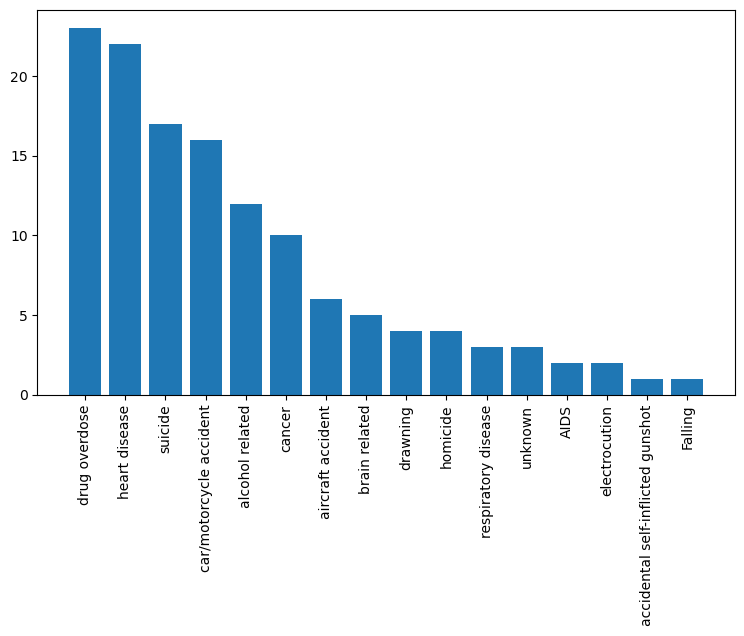

In [36]:
plt.figure(figsize=(9,5))
plt.bar(n_rock['cause'], n_rock['deaths'])
plt.xticks(rotation='vertical')

plt.show()

## Most common Cause o deaths

In [37]:
n_cause_death = musician['cause'].value_counts()

In [38]:
n_cause_death

heart disease                        104
homicide                              80
cancer                                50
drug overdose                         45
unknown                               41
car/motorcycle accident               35
suicide                               27
aircraft accident                     23
alcohol related                       20
respiratory disease                   20
brain related                         19
diabetes                               8
drawning                               6
AIDS                                   4
natural                                4
surgery                                3
accidental self-inflicted gunshot      3
electrocution                          2
tuberculosis                           2
Burned                                 1
Falling                                1
pancreatitis                           1
kidney related                         1
Name: cause, dtype: int64

# Correlation

### Genre - Cause of death

### Age - Cause of death

### Genre - Age